In [1]:
from trainer import cross_entropy2d
from torchvision import transforms

In [2]:
from matplotlib import pyplot as plt

In [3]:
import numpy as np

In [4]:
import fcn

In [5]:
import copy

In [6]:
import torch.nn.functional as F

In [7]:
from distutils.version import LooseVersion


def cross_entropy2d(input, target, weight=None, size_average=True):
    # input: (n, 2, h, w), target: (n, 1, h, w)
    n, c, h, w = input.size()
    _, _, th, tw = target.size()
    # log_p: (n, 2, h, w)
    if LooseVersion(torch.__version__) < LooseVersion('0.3'):
        # ==0.2.X
        log_p = F.log_softmax(input)
    else:
        # >=0.3
        log_p = F.log_softmax(input, dim=1)
    # log_p: (n*h*w, c)
    if h != th and w != tw:
        import pdb; pdb.set_trace()
    log_p = log_p.transpose(1, 2).transpose(2, 3).contiguous()
    log_p = log_p[target.view(n, h, w, 1).repeat(1, 1, 1, c) >= 0]
    log_p = log_p.view(-1, c)
    # target: (n*h*w,)
    mask = target >= 0
    target = target[mask]
    loss = F.nll_loss(log_p, target, weight=weight, reduction='mean')
    if size_average:
        loss /= mask.data.sum()
    return loss

In [8]:
import torch

# 현재 Setup 되어있는 device 확인
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
print(torch.cuda.get_device_name(device))


Available devices  2
Current cuda device  0
GeForce GTX 1080 Ti


In [9]:
# GPU 할당 변경하기
GPU_NUM = 1 # 원하는 GPU 번호 입력
device = torch.device(f'cuda:{GPU_NUM}' if torch.cuda.is_available() else 'cpu')
torch.cuda.set_device(device) # change allocation of current GPU
print ('Current cuda device ', torch.cuda.current_device()) # check

# Additional Infos
if device.type == 'cuda':
    print(torch.cuda.get_device_name(GPU_NUM))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(GPU_NUM)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(GPU_NUM)/1024**3,1), 'GB')


Current cuda device  1
GeForce GTX 1080 Ti
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


In [10]:
import os

import argparse
import datetime
import yaml

from tqdm import tqdm

from model import get_model
# from angio import ANGIODataset
from angio2 import ANGIODataset

from trainer import Trainer
from preprocessing import preprocess_image, preprocess_empty, preprocess_PIL, preprocess_tensor

from torchsummary import summary

# target image size
_HEIGHT = 512
_WIDTH = 512

# scale factor
_MIN_SCALE = 2.0
_MAX_SCALE = 3.0

def get_parameters(model, bias=None):
    for name, param in model.named_parameters():
        if name.startswith('backbone'):
            pass
        elif name.startswith('classifier'):
            names = name.split('.')
            if bias and 'bias' in names:
                yield param
            elif not bias and 'weight' in names:
                yield param
        else:
            raise ValueError('Unexpected module: %s' % str(m))

In [11]:
    parser = argparse.ArgumentParser(
        formatter_class=argparse.ArgumentDefaultsHelpFormatter,
    )
    parser.add_argument('-g', '--gpu', type=int, required=True, help='gpu id')
    parser.add_argument('--resume', help='checkpoint path')

    parser.add_argument(
        '--max-iteration', type=int, default=100000, help='max iteration'
    )
    parser.add_argument(
        '--lr', type=float, default=1.0e-10, help='learning rate',
    )
    parser.add_argument(
        '--weight-decay', type=float, default=0.0005, help='weight decay',
    )
    parser.add_argument(
        '--momentum', type=float, default=0.99, help='momentum',
    )
    args = parser.parse_args(['-g', 0])

    args.model = 'FCN'
    
    # PATH
    now = datetime.datetime.now()
    # here = os.path.dirname(os.path.abspath(__file__))
    here = os.path.dirname('.')

    
    args.out = os.path.join(here, 'logs', now.strftime('%Y%m%d_%H%M%S.%f'))

    os.makedirs(args.out)
    with open(os.path.join(args.out, 'config.yaml'), 'w') as f:
        yaml.safe_dump(args.__dict__, f, default_flow_style=False)

    # GPU
    os.environ['CUDA_VISIBLE_DEVICES'] = str(args.gpu)
    cuda = torch.cuda.is_available()

    # SEED
    torch.manual_seed(1337)
    if cuda:
        torch.cuda.manual_seed(1337)
    
    # DATASET LOADER
    kwargs = {'num_workers': 4, 'pin_memory': True} if cuda else {}
    
    train_angio_dataset = ANGIODataset('train', transform=preprocess_PIL(_HEIGHT, _WIDTH, _MIN_SCALE, _MAX_SCALE), logdir=args.out)
    valid_angio_dataset = ANGIODataset('valid', transform=preprocess_PIL(_HEIGHT, _WIDTH, _MIN_SCALE, _MAX_SCALE), logdir=args.out)

#     train_angio_dataset = ANGIODataset('train', transform=None, logdir=args.out)
#     valid_angio_dataset = ANGIODataset('valid', transform=None, logdir=args.out)

    
    train_loader = torch.utils.data.DataLoader(train_angio_dataset,
                                                batch_size=1, shuffle=True, **kwargs)
    valid_loader = torch.utils.data.DataLoader(valid_angio_dataset,
                                                batch_size=1, shuffle=True, **kwargs)

    # RESUME
    model = get_model()
    model.cuda()
    # summary(model, (3, 128, 128))

    start_epoch = 0
    start_iteration = 0
    if args.resume:
        checkpoint = torch.load(args.resume)
        model.load_state_dict(checkpoint['model_state_dict'])
        start_epoch = checkpoint['epoch']
        start_iteration = checkpoint['iteration']
    else:
        # vgg16 = torchfcn.models.VGG16(pretrained=True)
        # model.copy_params_from_vgg16(vgg16)
        pass
    if cuda:
        model = model.cuda()

    
    # OPTIMIZER
    optim = torch.optim.SGD(
    [
        {'params': get_parameters(model, bias=False)},
        {'params': get_parameters(model, bias=True),
         'lr': args.lr * 2, 'weight_decay': 0},
    ],
    lr=args.lr,
    momentum=args.momentum,
    weight_decay=args.weight_decay)

100%|██████████| 11/11 [00:00<00:00, 444.13it/s]
Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.5.0


In [12]:
data, target, filename = next(iter(train_loader))
score = model(data.cuda().float())
loss = cross_entropy2d(score['out'].cpu(), target.long().cpu(), size_average=False)

In [13]:
data.shape

torch.Size([1, 3, 512, 512])

In [14]:
data.type()

'torch.FloatTensor'

In [15]:
target.type()

'torch.ByteTensor'

In [ ]:
a = data > 0

In [20]:
data[0][0][:100][:100]

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [15]:
score = score['out']
target = target.long()

loss = cross_entropy2d(score, target.cuda(),
                       size_average=False)
loss_data = loss.data.item()
if np.isnan(loss_data):
    raise ValueError('loss is nan while validating')


In [16]:

imgs = data.data.cpu().numpy()
lbl_pred = score.data.max(1)[1].cpu().numpy()[:, :, :]
lbl_true = target.data.cpu().numpy()

In [17]:
print(imgs.shape, lbl_pred.shape, lbl_true.shape)


(1, 3, 512, 512) (1, 512, 512) (1, 1, 512, 512)


In [18]:
lt = lbl_true[0][0]
img = np.moveaxis(imgs[0], 0, -1)
lp = lbl_pred[0]

print(img.shape, lt.shape, lp.shape)

(512, 512, 3) (512, 512) (512, 512)


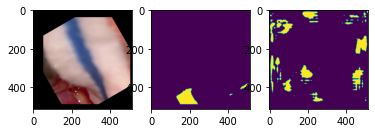

In [19]:
fig, axis = plt.subplots(1,3)
for i, item in enumerate([img, lt, lp]):
    axis[i].imshow(item)

In [20]:
np.all(lbl_true == 0.)

False

In [22]:
np.all(lbl_true >= 0.)

True

In [23]:
        mask_unlabeled = lbl_true == -1

In [ ]:
def visualize_segmentation(**kwargs):
    """Visualize segmentation.
    Parameters
    ----------
    img: ndarray
        Input image to predict label.
    lbl_true: ndarray
        Ground truth of the label.
    lbl_pred: ndarray
        Label predicted.
    n_class: int
        Number of classes.
    label_names: dict or list
        Names of each label value.
        Key or index is label_value and value is its name.
    Returns
    -------
    img_array: ndarray
        Visualized image.
    """
    img = kwargs.pop('img', None)
    lbl_true = kwargs.pop('lbl_true', None)
    lbl_pred = kwargs.pop('lbl_pred', None)
    n_class = kwargs.pop('n_class', None)
    label_names = kwargs.pop('label_names', None)
    if kwargs:
        raise RuntimeError(
            'Unexpected keys in kwargs: {}'.format(kwargs.keys()))

    if lbl_true is None and lbl_pred is None:
        raise ValueError('lbl_true or lbl_pred must be not None.')

    # c, h, w = img.shape
    # if c < h and c < w:
    #     img = img.reshape((h,w,c)).numpy()

    lbl_true = copy.deepcopy(lbl_true)
    lbl_pred = copy.deepcopy(lbl_pred)

    mask_unlabeled = None
    viz_unlabeled = None
    if lbl_true is not None:
        mask_unlabeled = lbl_true == -1
        lbl_true[mask_unlabeled] = 0
        viz_unlabeled = (
            np.random.random((lbl_true.shape[0], lbl_true.shape[1], 3)) * 255
        ).astype(np.uint8)
        if lbl_pred is not None:
            lbl_pred[mask_unlabeled] = 0

    vizs = []

    if lbl_true is not None:
        viz_trues = [
            img,
            label2rgb(lbl_true, label_names=label_names, n_labels=n_class),
            label2rgb(lbl_true, img, label_names=label_names,
                      n_labels=n_class),
        ]
        viz_trues[1][mask_unlabeled] = viz_unlabeled[mask_unlabeled]
        viz_trues[2][mask_unlabeled] = viz_unlabeled[mask_unlabeled]
        vizs.append(get_tile_image(viz_trues, (1, 3)))

    if lbl_pred is not None:
        viz_preds = [
            img,
            label2rgb(lbl_pred, label_names=label_names, n_labels=n_class),
            label2rgb(lbl_pred, img, label_names=label_names,
                      n_labels=n_class),
        ]
        if mask_unlabeled is not None and viz_unlabeled is not None:
            viz_preds[1][mask_unlabeled] = viz_unlabeled[mask_unlabeled]
            viz_preds[2][mask_unlabeled] = viz_unlabeled[mask_unlabeled]
        vizs.append(get_tile_image(viz_preds, (1, 3)))

    if len(vizs) == 1:
        return vizs[0]
    elif len(vizs) == 2:
        return get_tile_image(vizs, (2, 1))
    else:
        raise RuntimeError

In [77]:
def test(**kwargs):
    """Visualize segmentation.
    Parameters
    ----------
    img: ndarray
        Input image to predict label.
    lbl_true: ndarray
        Ground truth of the label.
    lbl_pred: ndarray
        Label predicted.
    n_class: int
        Number of classes.
    label_names: dict or list
        Names of each label value.
        Key or index is label_value and value is its name.
    Returns
    -------
    img_array: ndarray
        Visualized image.
    """
    img = kwargs.pop('img', None)
    lbl_true = kwargs.pop('lbl_true', None)
    lbl_pred = kwargs.pop('lbl_pred', None)
    n_class = kwargs.pop('n_class', None)
    label_names = kwargs.pop('label_names', None)
    if kwargs:
        raise RuntimeError(
            'Unexpected keys in kwargs: {}'.format(kwargs.keys()))

    if lbl_true is None and lbl_pred is None:
        raise ValueError('lbl_true or lbl_pred must be not None.')

    # c, h, w = img.shape
    # if c < h and c < w:
    #     img = img.reshape((h,w,c)).numpy()

    lbl_true = copy.deepcopy(lbl_true)
    lbl_pred = copy.deepcopy(lbl_pred)

    mask_unlabeled = None
    viz_unlabeled = None
    if lbl_true is not None:
        mask_unlabeled = lbl_true == -1
        lbl_true[mask_unlabeled] = 0
        viz_unlabeled = (
            np.random.random((lbl_true.shape[0], lbl_true.shape[1], 3)) * 255
        ).astype(np.uint8)
        if lbl_pred is not None:
            lbl_pred[mask_unlabeled] = 0

    vizs = []

    if lbl_true is not None:
        viz_trues = [
            img,
            fcn.utils.label2rgb(lbl_true, label_names=label_names, n_labels=n_class),
            fcn.utils.label2rgb(lbl_true, img, label_names=label_names,
                      n_labels=n_class),
        ]
        return viz_trues

        viz_trues[1][mask_unlabeled] = viz_unlabeled[mask_unlabeled]
        viz_trues[2][mask_unlabeled] = viz_unlabeled[mask_unlabeled]
        return viz_trues
        vizs.append(fcn.utils.get_tile_image(viz_trues, (1, 3)))
    
    return vizs

In [101]:
def _tile_images(imgs, tile_shape, concatenated_image):
    """Concatenate images whose sizes are same.
    @param imgs: image list which should be concatenated
    @param tile_shape: shape for which images should be concatenated
    @param concatenated_image: returned image.
        if it is None, new image will be created.
    """
    y_num, x_num = tile_shape
    one_width = imgs[0].shape[1]
    one_height = imgs[0].shape[0]
    if concatenated_image is None:
        if len(imgs[0].shape) == 3:
            n_channels = imgs[0].shape[2]
            assert all(im.shape[2] == n_channels for im in imgs)
            concatenated_image = np.zeros(
                (one_height * y_num, one_width * x_num, n_channels),
                dtype=np.float32,
            )
        else:
            concatenated_image = np.zeros(
                (one_height * y_num, one_width * x_num), dtype=np.uint8)
    for y in range(y_num):
        for x in range(x_num):
            i = x + y * x_num
            if i >= len(imgs):
                pass
            else:
                concatenated_image[y * one_height:(y + 1) * one_height,
                                   x * one_width:(x + 1) * one_width] = imgs[i]
    return concatenated_image



In [174]:
def tt(img, lbl):
    def bitget(byteval, idx):
        return ((byteval & (1 << idx)) != 0)

    def label_colormap(N=256):
        cmap = np.zeros((N, 3))
        for i in range(0, N):
            id = i
            r, g, b = 0, 0, 0
            for j in range(0, 8):
                r = np.bitwise_or(r, (bitget(id, 0) << 7 - j))
                g = np.bitwise_or(g, (bitget(id, 1) << 7 - j))
                b = np.bitwise_or(b, (bitget(id, 2) << 7 - j))
                id = (id >> 3)
            cmap[i, 0] = r
            cmap[i, 1] = g
            cmap[i, 2] = b
        cmap = cmap.astype(np.float32) / 255
        return cmap

    cmap = label_colormap(2)
    cmap = (cmap).astype(np.float32)

    lbl_viz = cmap[lbl]
    lbl_viz[lbl == -1] = (0, 0, 0)  # unlabeled
    
    import skimage
    import skimage.color
    import skimage.transform
    alpha = 0.5
    if img is not None:
        img_gray = skimage.color.rgb2gray(img)
        img_gray = skimage.color.gray2rgb(img_gray)
  
        # img_gray *= 255
        lbl_viz = alpha * lbl_viz + (1 - alpha) * img_gray
        return lbl_viz
        
        lbl_viz = lbl_viz.astype(np.uint8)
        
        

(512, 512, 3)


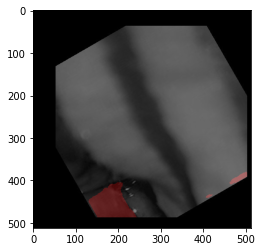

In [175]:
t = tt(img, lt)
print(t.shape)
plt.imshow(t)

float32
(512, 512, 3)


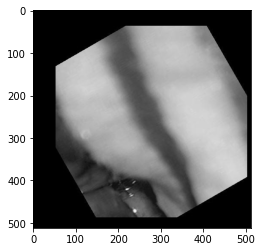

In [153]:
print(tt(img, lt).dtype)
print(tt(img, lt).shape)
plt.imshow(tt(img, lt))

uint8
(512, 512, 3)


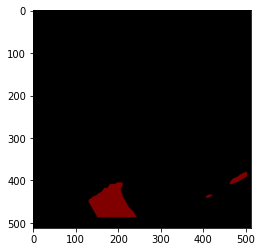

In [133]:
print(tt(img, lt).dtype)
print(tt(img, lt).shape)
plt.imshow(tt(img, lt))

float32
(2, 3)


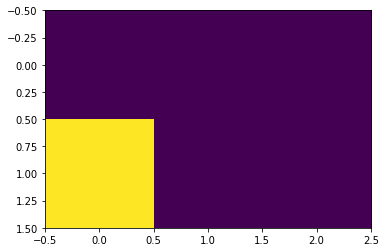

In [131]:
print(tt(img).dtype)
print(tt(img).shape)
plt.imshow(tt(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


float32
(512, 512, 3)


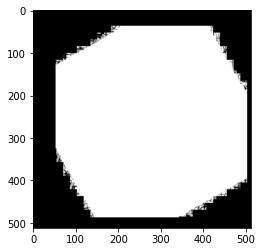

In [123]:
print(tt(img).dtype)
print(tt(img).shape)
plt.imshow(tt(img))

float32
(512, 512, 3)


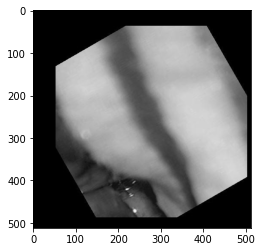

In [121]:
print(tt(img).dtype)
print(tt(img).shape)
plt.imshow(tt(img))

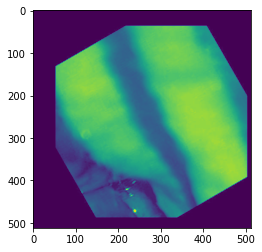

In [117]:
print(tt(img).dtype)
plt.imshow(tt(img))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


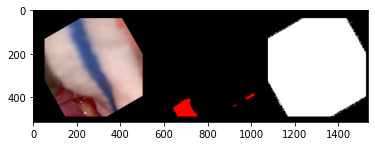

In [98]:
viz = test(
    lbl_pred=lp, lbl_true=lt, img=img, n_class=n_class)
t = np.hstack((viz[0], viz[1], viz[2]))
t.shape
plt.imshow(t)

In [102]:
tile = _tile_images(viz, (1,3), None)
tile.shape

(512, 1536, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


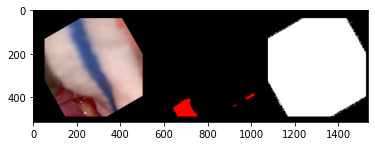

In [103]:
plt.imshow(tile)

In [79]:
t = np.hstack((viz[0], viz[1], viz[2]))
t.shape

(512, 1536, 3)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


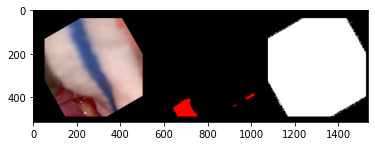

In [80]:
plt.imshow(t)

In [50]:
n_class = 2

In [51]:
viz = test(
    lbl_pred=lp, lbl_true=lt, img=img, n_class=n_class)

In [57]:
viz[0].shape

(512, 1536, 3)

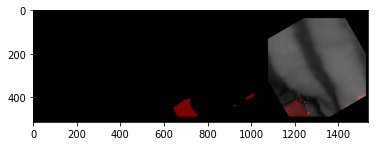

In [62]:
plt.imshow(viz[0])

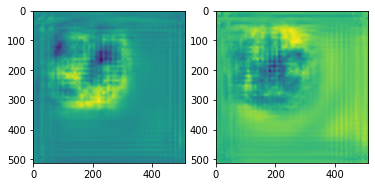

In [21]:
fig, axis = plt.subplots(1,2)
for i, item in enumerate(score['out'].cpu().detach().numpy()[0]):
    axis[i].imshow(item)

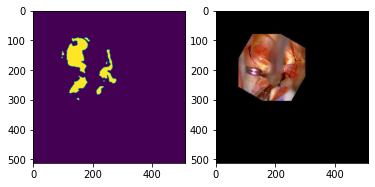

In [22]:
fig, axis = plt.subplots(1,2)
axis[0].imshow(target.numpy().squeeze())
axis[1].imshow(np.moveaxis(data.numpy()[0], 0, -1))

torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False
torch.ByteTensor torch.Size([1, 1, 512, 512]) torch.FloatTensor torch.Size([1, 3, 512, 512])
False


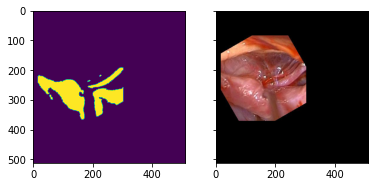

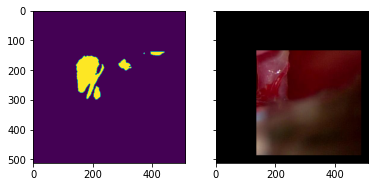

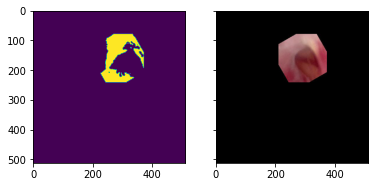

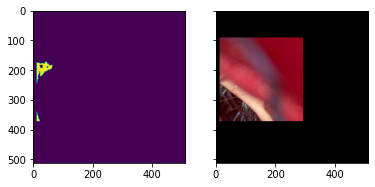

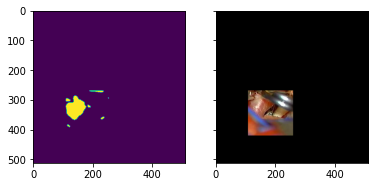

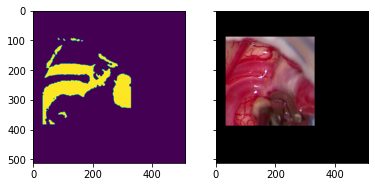

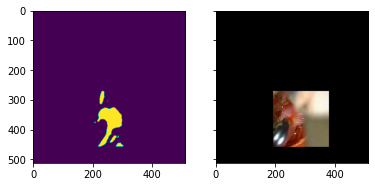

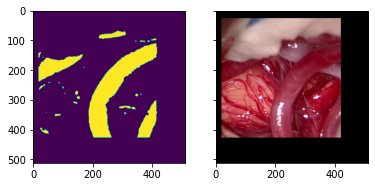

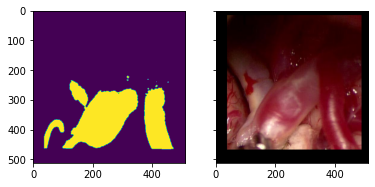

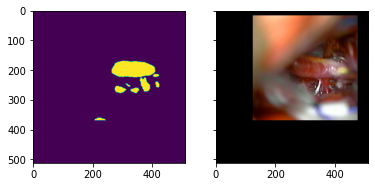

In [8]:
for i, (data, target, filename) in zip(range(10), train_loader):
    f, (ax1, ax2) = plt.subplots(1, 2, sharey=True)
    print(target.type(), target.shape, data.type(), data.shape)
    # print(target.numpy() == torch.zeros((1,1,512,512)).byte().numpy())
    print(np.all(target.numpy() == 0))
    ax1.imshow(target.numpy().squeeze())
    ax2.imshow(np.moveaxis(data.numpy()[0], 0, -1))